In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

# Load data

In [2]:
observations = pd.read_csv('TherapeuticTouchData.csv')
observations.T

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
y,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,1,0,1
s,S01,S01,S01,S01,S01,S01,S01,S01,S01,S01,...,S28,S28,S28,S28,S28,S28,S28,S28,S28,S28


In [3]:
# Load the complete data ignoring participants
all_obs = observations['y'].values
print(all_obs)
print(len(all_obs))
print(sum(all_obs))

[1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0
 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0
 1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1
 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1
 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1
 1 0 0 0 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0
 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1]
280
123


# Independed Measures
Assume measures to be indepeded of each other (280 repeated measures).

Try to model the observed data using a Bernoulli distribution, and use pymc3 to estimate the p value of the distribution.

In [4]:
with pm.Model() as coin_model: 
    p_prior = pm.Uniform('p', 0, 1)  
    
    # Specify likelihood using Bernoulli object.
    like = pm.Bernoulli('likelihood', p=p_prior, observed=all_obs)
    model_samples = pm.sample(2000)

Distribution [0.42 , (0.44) , 0.46]


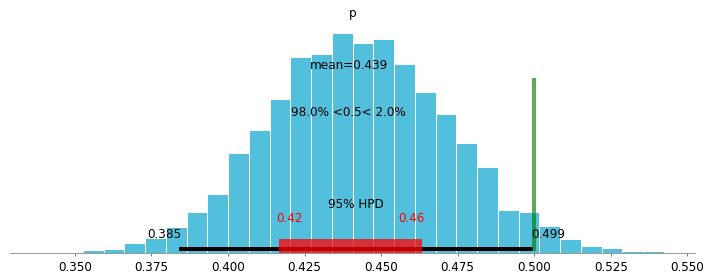

In [6]:
# Show the distribution of samples, in relation to the null hypothesis (p = 0.5)
q25 = np.percentile(model_samples.get_values('p'), 25)
q50 = np.percentile(model_samples.get_values('p'), 50)
q75 = np.percentile(model_samples.get_values('p'), 75)
print('Distribution [%2.2f , (%2.2f) , %2.2f]' % (q25, q50, q75))

pm.plot_posterior(model_samples, color='#52BFDC', rope=[np.round(q25, 2), np.round(q75, 2)], point_estimate='mean', ref_val=0.5, figsize=(10,4))
plt.show()

## Discussion
Assuming all trials beeing independed of each other (repeated meassures), the above plot shows that the data can be best explained by a Bernoulli distribution with a p = 0.439.

The null hypothesis (green line) that the practicionairs are as good as chance is therfore very unlikely (less than 2.5%).

Aka: Meaning that they beform much worse than random guessing??

# Results by subject
In this section, we will look at the result distribution by subjects, looking at the number of correct answers for each subject.

There are 1024 (2 ** 10) sequences of correct and wrong results. If all of them are equally likely, throwing 8 out of 10 (binominal coefficient sp.special.binom(10, 8) = 45 , 45 / 1024 = 0.0439453125 . Corresponing to a chance of less than 5% to be a random coinsidance. 

The experimentor therefor labes successfull practicioners (those being able to sense 'human energy fields') as such that success in at least 8 out of 10 trials.

In [4]:
bysubject = observations.groupby('s').sum()
bysubject.T

s,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,...,S19,S20,S21,S22,S23,S24,S25,S26,S27,S28
y,1,2,3,3,3,3,3,3,3,3,...,5,5,5,5,6,6,7,7,7,8


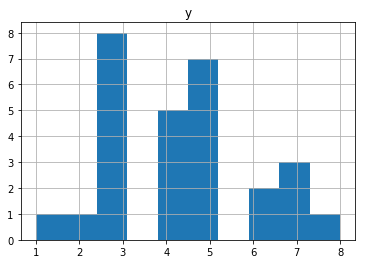

In [5]:
# Print distribution of successfull answers
bysubject.hist()
plt.show()

## Modeling
Assume the data can be modeld using a Poisson distribution with a mean between 1 and 10.
use MCMC to estimate the distribution mean for given data.

In [6]:
with pm.Model() as coin_model: 
    mu_prior = pm.Uniform('mu', 1, 10)  
    
    # Specify likelihood using Poission distribution
    like = pm.Poisson('likelihood', mu=mu_prior, observed=bysubject)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    model_samples = pm.sample(200000, step, start=start, progressbar=True)

logp = -60.282, ||grad|| = 12.682: 100%|██████████| 7/7 [00:00<00:00, 725.32it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu_interval__]
100%|██████████| 200500/200500 [00:27<00:00, 7412.29it/s]
The number of effective samples is smaller than 25% for some parameters.


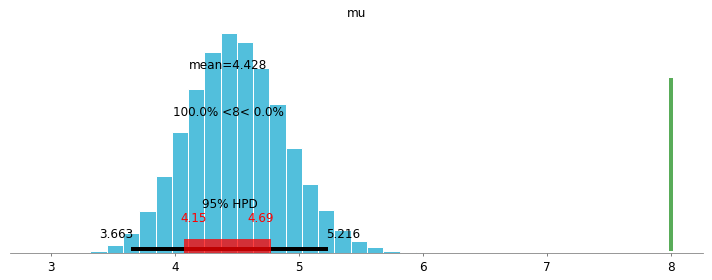

In [7]:
# Show the distribution of samples, in relation to the null hypothesis (mu = 8)
q25 = np.percentile(model_samples.get_values('mu'), 25)
q50 = np.percentile(model_samples.get_values('mu'), 50)
q75 = np.percentile(model_samples.get_values('mu'), 75)


pm.plot_posterior(model_samples, color='#52BFDC', rope=[np.round(q25, 2), np.round(q75, 2)], point_estimate='mean', ref_val=8, figsize=(10,4))
plt.show()

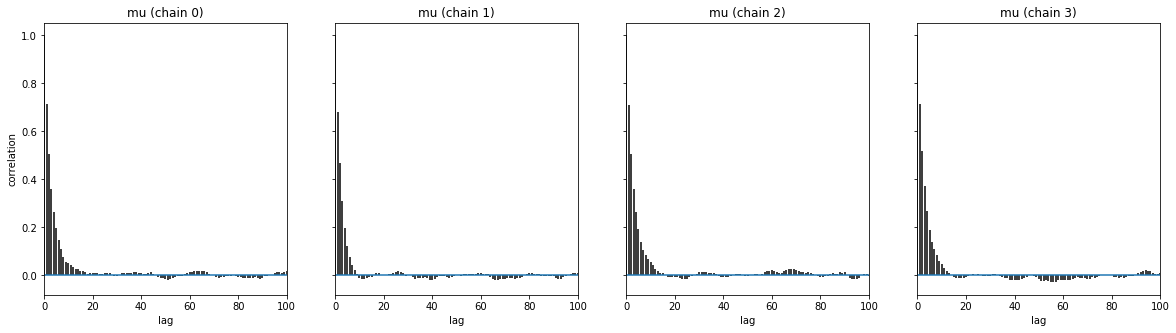

In [16]:
# Look at the autocorrelation plot in order to verify that the liklihood function was choosen well
# see http://nbviewer.jupyter.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%201.%20Estimating%20model%20parameters.ipynb

# We want to see values dropping close to zero and oszilate arround the zero line ...
pm.autocorrplot(model_samples[:20000], varnames=['mu'], figsize=(20, 5))
plt.show()

# Discussion
The above plot showes a poission distribution best fitting the given results per subjects.
It shows that on average a subject is able to provide the correct answer in 4.429 out of 10 cases.

Assuming that an *real* TT practitioner would be able to on average respond correctly in 8 out of 10 cases, the
data shows clearly that the test participants are not part of that group.

# Conclution
Both analysis (independed meassures, and by subjects) show that the test participants where unable to sense a 'human energy field'

In case of the independed meassures the data shows that the participants are performing most likly worse than random guessing, but the by subjects analysis shows, that give the data there is no chance that they are able to practise TT.